In [4]:
from google.cloud import bigquery
from google.cloud import storage
import pandas as pd
import numpy as np

from scipy import stats
from dython.nominal import associations

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot  as plt
import math


In [28]:
isLastUpdate=True

IsNewData=True

label='severity_id'
labelName='severity_name'

bucket_name="gs://smart-ml-pongthorn"

threshold_x_sd = 3

if IsNewData==False:
    removeCols=['id','updated_at','imported_at']
    exCateCorr=[]
else:
 removeCols=['updated_at'] 
 exCateCorr=['id','imported_at']




dateCols=['open_datetime','close_datetime','response_datetime','resolved_datetime']

numbericCols=['count_detail','open_to_close_hour','open_to_response_hour','response_to_resolved_hour']
#numbericCols=['count_detail','open_to_close_hour']

cateCols=['sla','product_type','brand','service_type','incident_type']


imported_to='2023-03-13'


In [29]:
def load_data_bq(sql:str):
 client_bq = bigquery.Client()
 query_result=client_bq.query(sql)
 df_all=query_result.to_dataframe()
 return df_all

In [30]:
print(f"NewData={IsNewData}")
if IsNewData==True:
    sql_all=f"""
    SELECT  id,
    severity_id,severity_name,
    count_detail,sla,
    product_type,brand,service_type,incident_type,
    open_datetime,  close_datetime, response_datetime,resolved_datetime, 
    updated_at,imported_at
    FROM `pongthorn.SMartDW.incident` WHERE imported_at>= '{imported_to}'
    order by imported_at
    """
    
    file_name="New_Incident.csv"
    table_id = "pongthorn.SMartML.new_incident"
    
    
else:
    sql_all=f"""
    SELECT  id,
    severity_id,severity_name,
    count_detail,sla,
    product_type,brand,service_type,incident_type,
    open_datetime,  close_datetime, response_datetime,resolved_datetime, 
    updated_at,imported_at
    FROM `pongthorn.SMartDW.incident` WHERE imported_at< '{imported_to}'
    order by imported_at
    """
    
    file_name="ML_Incident.csv"
    table_id = "pongthorn.SMartML.ml_incident"

print(f"Load Data to {table_id} and Save as csv file  to {file_name}")
    
if isLastUpdate:
    print("Load data from Bigquery")
    df_all=load_data_bq(sql_all)
    if len(df_all)>0:
     df_all.to_csv(f'data/{file_name}',index=False)
    else:
     print("No records from bigquery")   
else:
    print("Load data from Load CSV")
    df_all=pd.read_csv(f'data/{file_name}',parse_dates=dateCols)
    
df_all=df_all.drop_duplicates(subset=['id'],keep='first')

print("Update")
print(f"Max Last Import ={df_all['imported_at'].max()}   and  Update={df_all['updated_at'].max()}")



df_all.info()


NewData=True
Load Data to pongthorn.SMartML.new_incident and Save as csv file  to New_Incident.csv
Load data from Bigquery
Update
Max Last Import =2023-03-18 21:00:07.029961   and  Update=2023-03-18 08:15:24
<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 31
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 32 non-null     Int64         
 1   severity_id        32 non-null     Int64         
 2   severity_name      32 non-null     object        
 3   count_detail       32 non-null     Int64         
 4   sla                32 non-null     object        
 5   product_type       32 non-null     object        
 6   brand              32 non-null     object        
 7   service_type       32 non-null     object        
 8   incident_type      32 non-null     object        
 9   open_datetime      32 non-null     datetime64[ns]
 10  close_datetime     32 no

# Manage Numberic Cols

In [31]:
start_end_list=[ ['open_datetime','close_datetime'],['open_datetime','response_datetime'],['response_datetime','resolved_datetime']]
listDiffDateDeltaCols=[]
listDiffHourCols=[]
for item  in  start_end_list:
   diff_str=f"{item[0]}_to_{item[1]}" 
   diff_str=diff_str.replace('_datetime','')  
   listDiffDateDeltaCols.append(diff_str)
   df_all[diff_str]=df_all[item[1]]-df_all[item[0]]
    
   diff_hour=f'{diff_str}_hour'
   listDiffHourCols.append(diff_hour)
   df_all[diff_hour] = df_all[diff_str].apply(lambda x:  x.total_seconds() / (60*60) if x is not np.nan else np.nan  )
xScoreDiffHourCols=[]
for col in listDiffHourCols:
  z_col=f"zscore_{col}"   
  df_all[z_col] = np.abs(stats.zscore(df_all[col]))   
  xScoreDiffHourCols.append(z_col)  
#remove oulier

for col in  xScoreDiffHourCols:
  df_all=df_all.query(f"{col}<@threshold_x_sd")

In [32]:
print(df_all.shape)
df_all.tail()

(29, 24)


,id,severity_id,severity_name,count_detail,sla,product_type,brand,service_type,incident_type,open_datetime,...,imported_at,open_to_close,open_to_close_hour,open_to_response,open_to_response_hour,response_to_resolved,response_to_resolved_hour,zscore_open_to_close_hour,zscore_open_to_response_hour,zscore_response_to_resolved_hour
26,2426,2,Major,7,24x7 4Hrs Resolution Time,Server,HPE,Incident,General Incident,2023-03-13 10:00:00,...,2023-03-16 21:00:07.630594,2 days 17:00:00,65.000000,0 days 00:08:00,0.133333,2 days 16:52:00,64.866667,0.234933,0.215876,0.202585
28,2449,3,Minor,1,24x7 6Hrs Resolution Time,Software,eUnite,Incident,Software,2023-01-17 10:15:00,...,2023-03-17 21:00:08.110929,0 days 06:45:00,6.750000,0 days 00:05:00,0.083333,0 days 05:40:00,5.666667,0.344207,0.232891,0.361020
29,2446,4,Cosmatic,3,24x7 4Hrs Resolution Time,Storage,Veritas,Request,Software,2023-03-16 08:55:00,...,2023-03-17 21:00:08.110929,1 days 03:39:00,27.650000,0 days 00:00:00,0.000000,1 days 03:39:00,27.650000,0.305000,0.261250,0.302186
30,2448,2,Major,3,24x7 4Hrs Resolution Time,Storage,NetApp,Incident,Hard Disk Drive Failure,2023-03-16 14:50:00,...,2023-03-17 21:00:08.110929,0 days 06:32:00,6.533333,0 days 00:40:00,0.666667,0 days 00:00:00,0.000000,0.344613,0.034384,0.376185
31,2447,2,Major,3,24x7 4Hrs Resolution Time,Server,HPE,Incident,Network Cable Failure,2023-03-16 08:34:00,...,2023-03-18 21:00:07.029961,1 days 15:25:00,39.416667,0 days 00:00:00,0.000000,1 days 10:26:00,34.433333,0.282926,0.261250,0.284032


# Find any rows  contain 0

In [33]:

# if>5%  remove column, else judge to remove 0 value 
# remove coundetail because mostly, there are few value 1,2 items
allRows=df_all.shape[0]
for col in numbericCols:
    zeroRows=len(df_all.query(f"{col}==0"))
    pctZeroHour=round(zeroRows/allRows*100,1)
    print(f"No. 0-hour row on {col} = {zeroRows}({pctZeroHour} %)")

No. 0-hour row on count_detail = 0(0.0 %)
No. 0-hour row on open_to_close_hour = 0(0.0 %)
No. 0-hour row on open_to_response_hour = 6(20.7 %)
No. 0-hour row on response_to_resolved_hour = 3(10.3 %)


# Bining Range

In [34]:
def explore_ranges_numberic_val(col,rangeList):
    print(col)
    rangeList.sort()
    return pd.cut(df_all[col],rangeList, right=True).value_counts()
range1= [0,24, 168, 360, 720,math.floor(df_all['open_to_close_hour'].max())]
print(explore_ranges_numberic_val('open_to_close_hour',range1))
print("=======================================================")

range2= [0,24, 168, 360, 720,math.floor(df_all['response_to_resolved_hour'].max())]
print(explore_ranges_numberic_val('response_to_resolved_hour',range2))
print("=======================================================")

range3= [0,4, 8, 12, 24,math.floor(df_all['open_to_response_hour'].max())]
print(explore_ranges_numberic_val('open_to_response_hour',range3))
print("=======================================================")

range4= [0,2, 4,math.floor(df_all['count_detail'].max())]
print(explore_ranges_numberic_val('count_detail',range4))
print("=======================================================")

open_to_close_hour
(0, 24]       17
(24, 168]      9
(168, 360]     2
(524, 720]     1
(360, 524]     0
Name: open_to_close_hour, dtype: int64
response_to_resolved_hour
(0, 24]       17
(24, 168]      7
(168, 360]     1
(524, 720]     1
(360, 524]     0
Name: response_to_resolved_hour, dtype: int64
open_to_response_hour
(0, 1]      21
(1, 4]       2
(4, 8]       0
(8, 12]      0
(12, 24]     0
Name: open_to_response_hour, dtype: int64
count_detail
(0, 2]    15
(2, 4]    10
(4, 8]     4
Name: count_detail, dtype: int64


In [35]:
print("remove some cate featurs that have imcompelte data")
numColsRemove=['open_to_response_hour','count_detail'] 
numbericCols=[x for x in numbericCols if x not in numColsRemove]   
numbericCols

remove some cate featurs that have imcompelte data


['open_to_close_hour', 'response_to_resolved_hour']

In [36]:
# remove response_to_resolved_hour ,it doesn't make any sense
df_all=df_all.query('response_to_resolved_hour!=0')

In [37]:
removeCols=removeCols+dateCols+xScoreDiffHourCols+listDiffDateDeltaCols+numColsRemove
df_all=df_all.drop(columns=removeCols)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 1 to 31
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         26 non-null     Int64         
 1   severity_id                26 non-null     Int64         
 2   severity_name              26 non-null     object        
 3   sla                        26 non-null     object        
 4   product_type               26 non-null     object        
 5   brand                      26 non-null     object        
 6   service_type               26 non-null     object        
 7   incident_type              26 non-null     object        
 8   imported_at                26 non-null     datetime64[ns]
 9   open_to_close_hour         26 non-null     float64       
 10  response_to_resolved_hour  26 non-null     float64       
dtypes: Int64(2), datetime64[ns](1), float64(2), object(6)
memory usage: 2.5+ 

In [38]:
df_all[numbericCols].describe()

,open_to_close_hour,response_to_resolved_hour
count,26.000000,26.000000
mean,64.607051,53.785897
std,113.169393,111.809478
min,0.116667,0.100000
25%,4.370833,1.266667
50%,11.875000,6.441667
75%,77.283333,57.258333
max,524.183333,524.050000


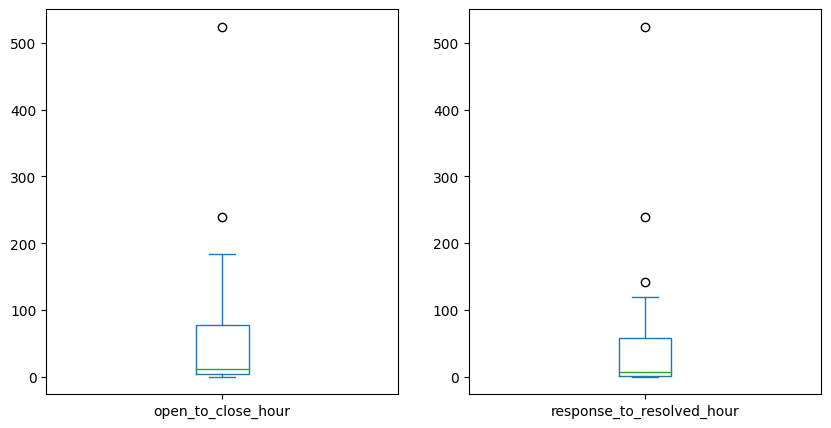

In [39]:
df_all[numbericCols].plot(kind='box',subplots=True,layout=(1,len(numbericCols)),sharex=False, sharey=False,figsize=(10,5))
plt.show()

array([[<Axes: xlabel='open_to_close_hour', ylabel='open_to_close_hour'>,
        <Axes: xlabel='response_to_resolved_hour', ylabel='open_to_close_hour'>],
       [<Axes: xlabel='open_to_close_hour', ylabel='response_to_resolved_hour'>,
        <Axes: xlabel='response_to_resolved_hour', ylabel='response_to_resolved_hour'>]],
      dtype=object)

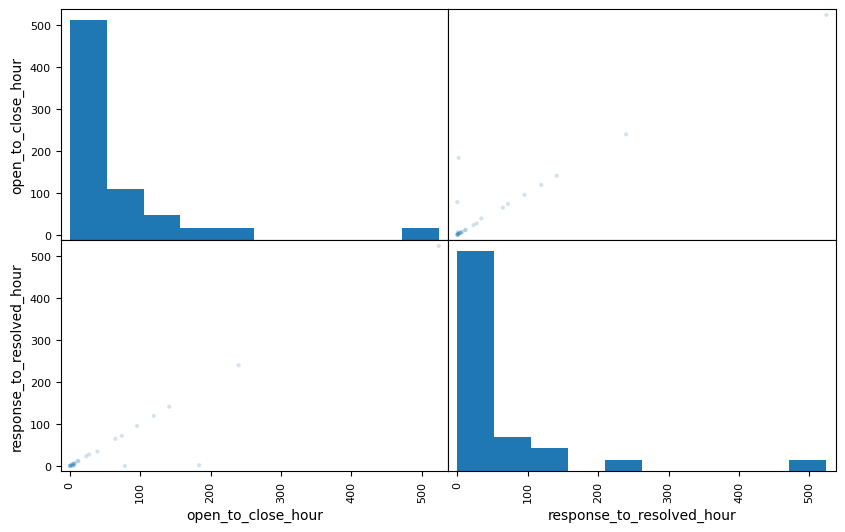

In [40]:
pd.plotting.scatter_matrix(df_all[numbericCols], alpha=0.2,figsize=(10,6))

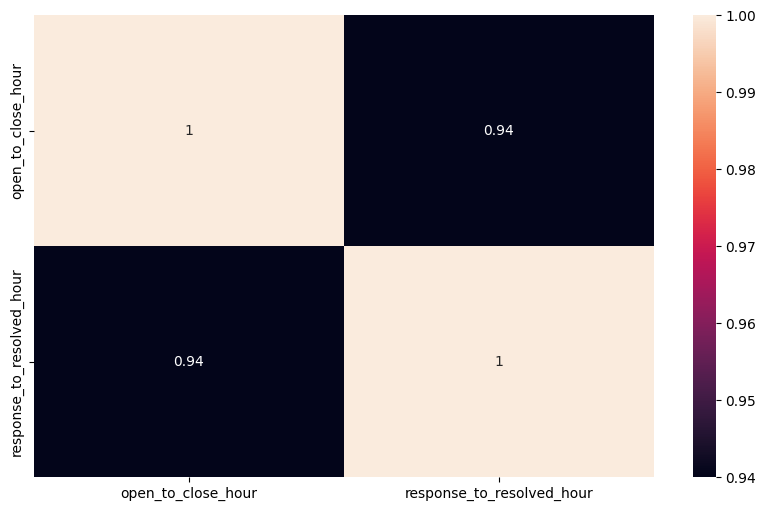

In [41]:
corr_df = df_all[numbericCols].corr ()  
corr_df = corr_df .round(2)

fig = plt.figure(figsize = (10, 6))
heatmap = sns. heatmap(corr_df, annot = True) 
plt. show ()

# Manage Categorical Cols

In [42]:
VBar=['brand','incident_type']
HBar=[ x for x in cateCols if x not in VBar]
HBar.insert(0,'severity_name')

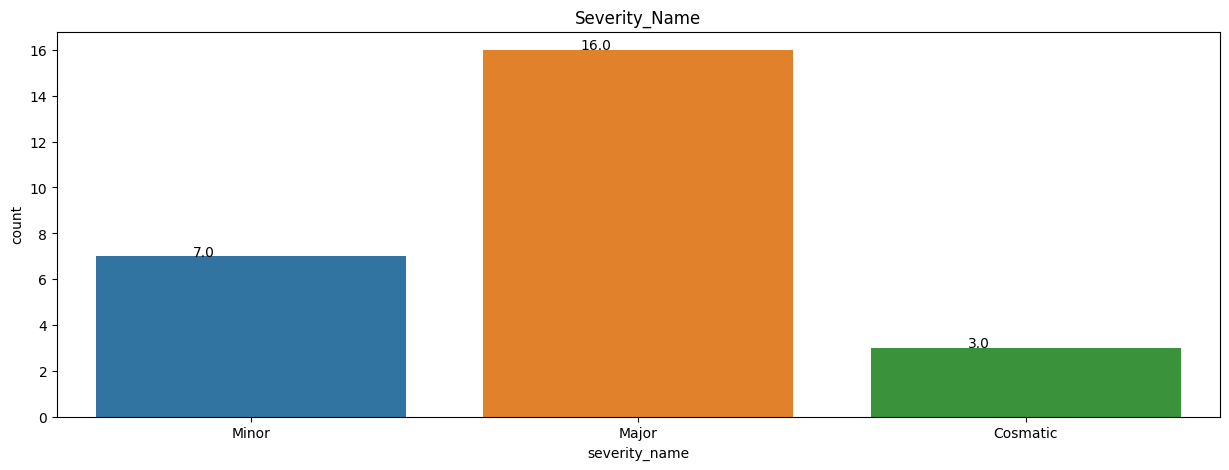

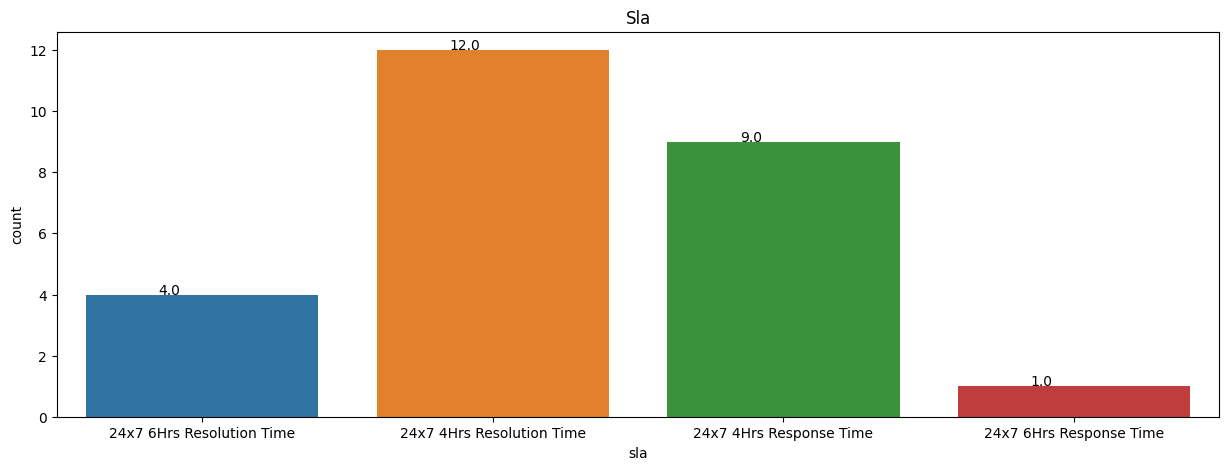

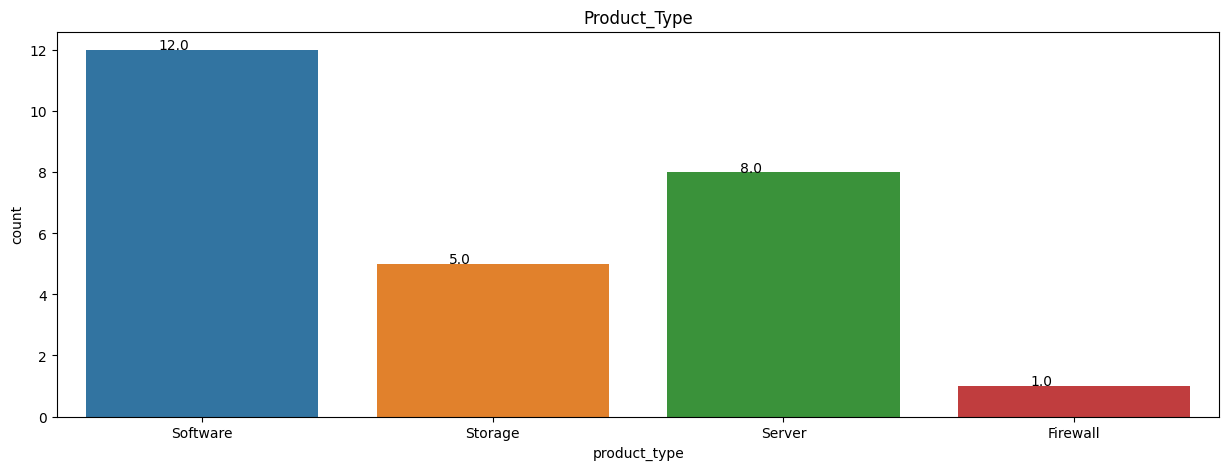

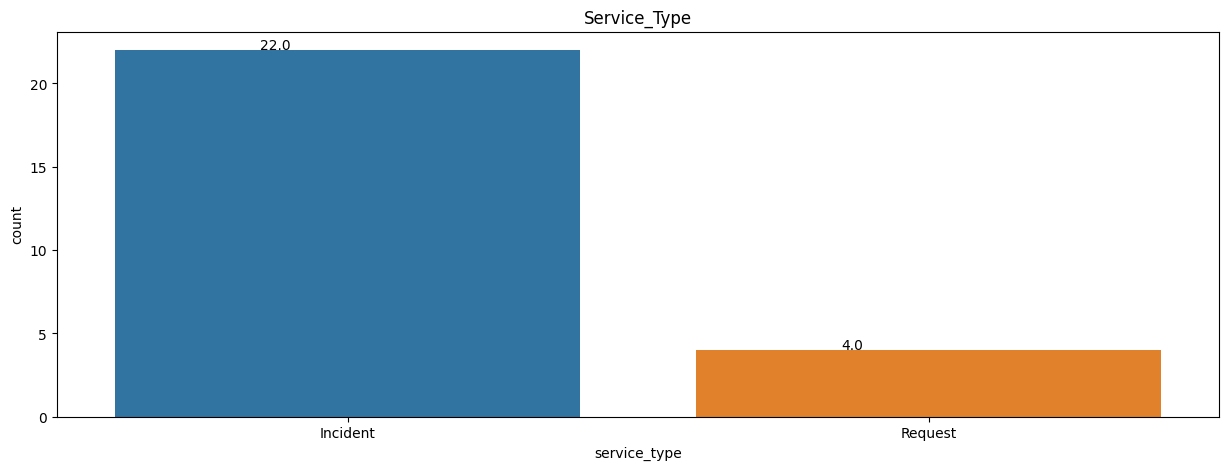

In [43]:
for col in HBar:
    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=col, data=df_all,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(col.title())
    plt.show()

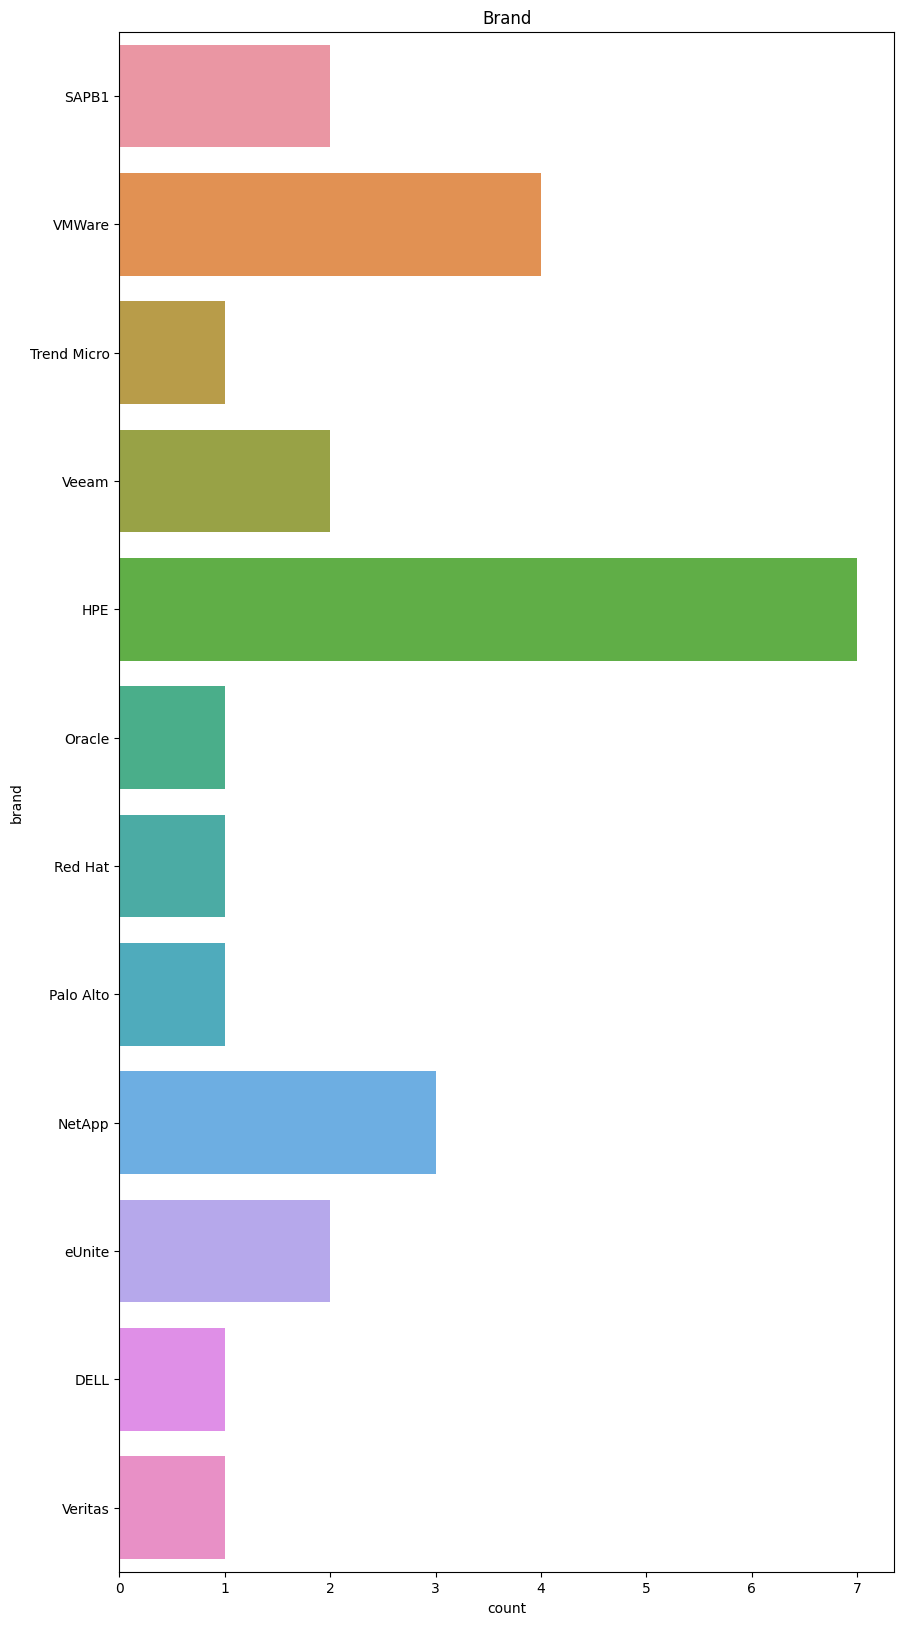

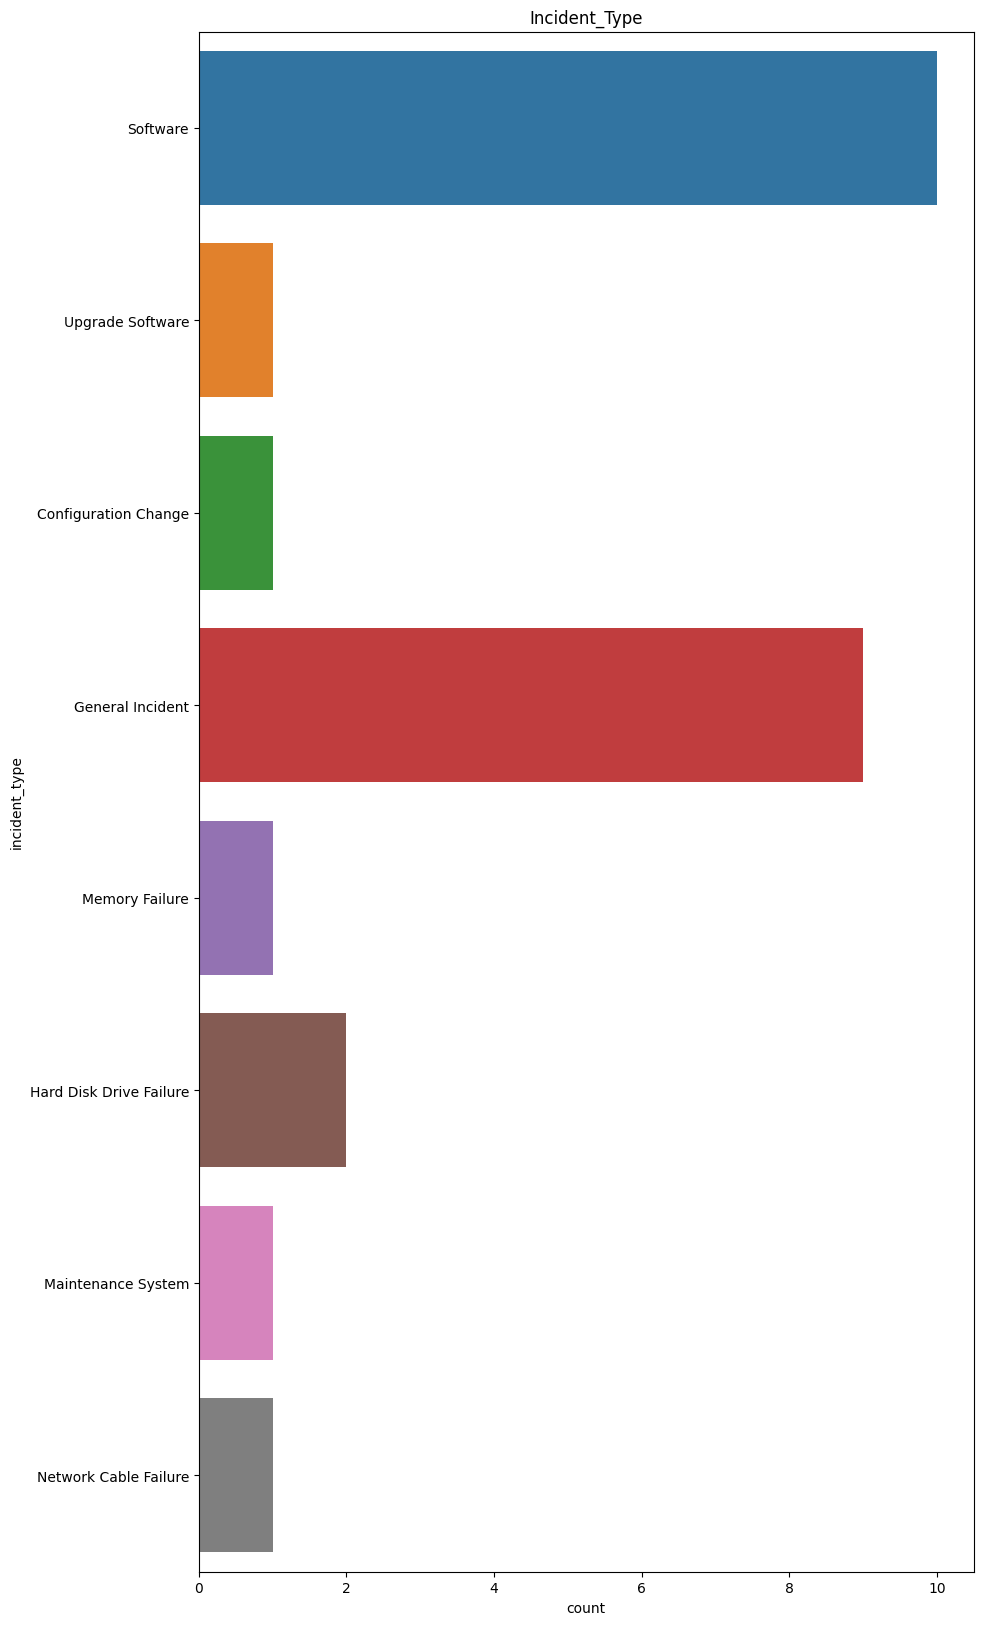

In [44]:
for col in VBar:
    fig , ax = plt.subplots(figsize=(10,20))
    ax =sns.countplot(y=col, data=df_all)
    plt.title(col.title())
    plt.show()

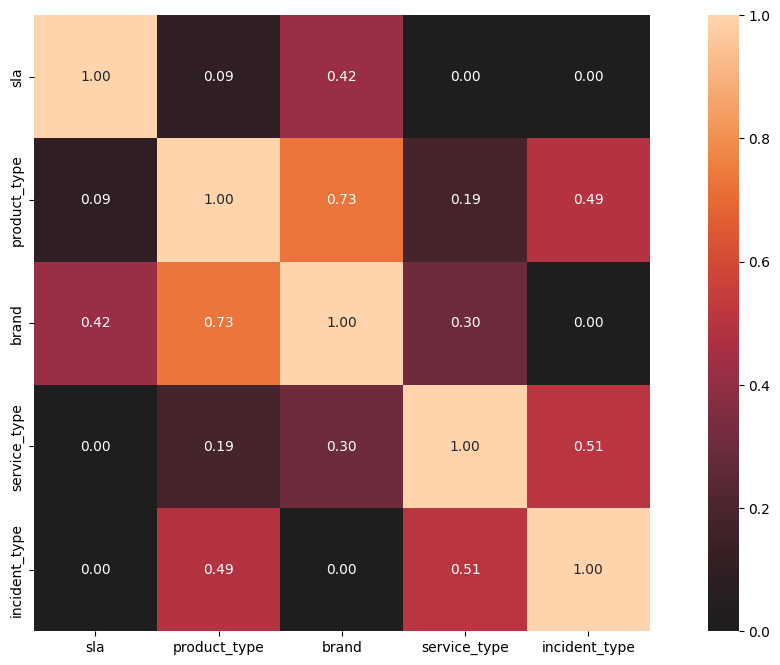

In [46]:
complete_correlation= associations(df_all[ cateCols ], figsize=(15,8))

In [47]:
# CSV_SCHEMA = [
#       bigquery.SchemaField("severity_id", "INTEGER"),
#       bigquery.SchemaField("severity_name", "STRING"),
#       bigquery.SchemaField("sla", "STRING"),
#       bigquery.SchemaField("product_type", "STRING"),
#       bigquery.SchemaField("brand", "STRING"),
#       bigquery.SchemaField("service_type", "STRING"),
#       bigquery.SchemaField("incident_type", "STRING"),
#       bigquery.SchemaField("open_to_close_hour", "FLOAT64"),
#       bigquery.SchemaField("response_to_resolved_hour", "FLOAT64"),

#   ]


df_all.to_csv(f"data/{file_name}",index=False)
df_all.to_csv(f"{bucket_name}/{file_name}",index=False) 


In [48]:


client = bigquery.Client()
def loadDataFrameToBQ():
    try:
        job_config = bigquery.LoadJobConfig(
            write_disposition="WRITE_TRUNCATE",
        )

        job = client.load_table_from_dataframe(
            df_all, table_id, job_config=job_config
        )
        job.result()  # Wait for the job to complete.
        print("Total ", len(df_all), "Imported igquery successfully")

    except BadRequest as e:
        print("Bigquery Error\n")
        for e in job.errors:
            print('ERROR: {}'.format(e['message']))

try:
    loadDataFrameToBQ()
except Exception as ex:
    raise ex


Total  26 Imported igquery successfully
